<a href="https://colab.research.google.com/github/annefrancine/DataScience_Estiam/blob/main/autoencodeur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Auto-encodeur : Les auto-encodeurs sont des algorithmes d’apprentissage non supervisé à base de réseaux de neurones artificiels, qui permettent de construire une nouvelle représentation d’un jeu de données. Généralement, celle-ci est plus compacte, et présente moins de descripteurs, ce qui permet de réduire la dimensionnalité du jeu de données. L’architecture d’un auto-encodeur est constitué de deux parties : l’encodeur et le décodeur.

L’encodeur est constitué par un ensemble de couches de neurones, qui traitent les données afin de construire de nouvelles représentations dites “encodées”. À leur tour, les couches de neurones du décodeur, reçoivent ces représentations et les traitent afin d’essayer de reconstruire les données de départ. Les différences entre les données reconstruites et les données initiales permettent de mesurer l’erreur commise par l’auto-encodeur. L’entraînement consiste à modifier les paramètres de l’auto-encodeur afin de réduire l’erreur de reconstruction mesurée sur les différents exemples du jeu de données.

La plupart du temps, on ne s’intéresse pas à la dernière couche du décodeur, qui contient uniquement la reconstruction des données initiales, mais plutôt à la nouvelle représentation créée par l’encodeur.

L’architecture la plus simple d’un auto-encodeur est semblable à un perceptron multicouches. Cependant, en fonction des données traitées, on peut utiliser différentes topologies de réseaux de neurones. Par exemple, des couches convolutives afin d’analyser des images ou des couches de neurones récurrentes pour traiter des séries temporelles ou des séquences.

À noter qu’à la différence d’un grand nombre de réseaux de neurones, les auto-encodeurs peuvent être entraînés de manière non-supervisée, ce qui permet d’appliquer ces méthodes à des jeux de données non annotés.

La figure suivante schématise un auto-encodeur simple, dont l’encodeur (encoder) traite des images (inputs), afin de les représenter comme des points dans un espace à deux dimensions (encoded representation), puis décode cette représentation (decoder), afin de retrouver les données de départ (output).

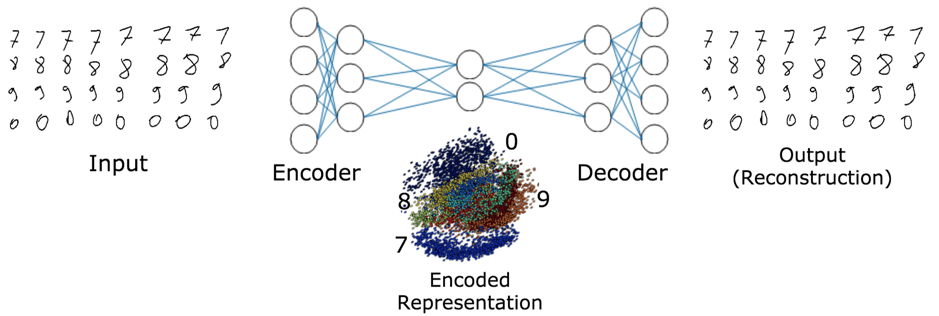

## MovieLens dataset¶
https://grouplens.org/datasets/movielens/



In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable


In [2]:
from google.colab import files
uploaded = files.upload()

Saving movies.dat to movies.dat
Saving ratings.dat to ratings.dat
Saving users.dat to users.dat


In [3]:
from google.colab import files
uploaded = files.upload()

Saving u1.base to u1.base
Saving u1.test to u1.test


## Charger dataset

In [4]:
movies = pd.read_csv('movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
users = pd.read_csv('users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')

In [5]:
#train et test dataset
training_set = pd.read_csv('u1.base', delimiter = '\t')
training_set = np.array(training_set, dtype = 'int')
test_set = pd.read_csv('u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')

In [6]:
# Nombre d'utilisateurs et de films
nb_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))

In [7]:
# Conversion de données en matrice avec les utilisateurs en lignes et les films en colonnes
def convert(data):
    new_data = [] 
    for id_users in range(1, nb_users + 1): 
        id_movies = data[:,1][data[:,0] == id_users] 
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

In [8]:
training_set = convert(training_set)
test_set = convert(test_set)

In [9]:
# Création Torch Tensors
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

In [10]:
# création RN
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_movies)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x


In [11]:
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

In [12]:
# Training neural network
nb_epoch = 200

for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0. 
    for id_user in range(nb_users): 
        input = Variable(training_set[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt(loss.data*mean_corrector)
            s += 1.
            optimizer.step()
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: tensor(1.7721)
epoch: 2 loss: tensor(1.0965)
epoch: 3 loss: tensor(1.0534)
epoch: 4 loss: tensor(1.0384)
epoch: 5 loss: tensor(1.0311)
epoch: 6 loss: tensor(1.0265)
epoch: 7 loss: tensor(1.0237)
epoch: 8 loss: tensor(1.0221)
epoch: 9 loss: tensor(1.0208)
epoch: 10 loss: tensor(1.0198)
epoch: 11 loss: tensor(1.0187)
epoch: 12 loss: tensor(1.0183)
epoch: 13 loss: tensor(1.0179)
epoch: 14 loss: tensor(1.0176)
epoch: 15 loss: tensor(1.0172)
epoch: 16 loss: tensor(1.0168)
epoch: 17 loss: tensor(1.0168)
epoch: 18 loss: tensor(1.0166)
epoch: 19 loss: tensor(1.0164)
epoch: 20 loss: tensor(1.0162)
epoch: 21 loss: tensor(1.0160)
epoch: 22 loss: tensor(1.0160)
epoch: 23 loss: tensor(1.0159)
epoch: 24 loss: tensor(1.0157)
epoch: 25 loss: tensor(1.0157)
epoch: 26 loss: tensor(1.0159)
epoch: 27 loss: tensor(1.0154)
epoch: 28 loss: tensor(1.0152)
epoch: 29 loss: tensor(1.0127)
epoch: 30 loss: tensor(1.0121)
epoch: 31 loss: tensor(1.0096)
epoch: 32 loss: tensor(1.0096)
epoch: 33 loss: t

In [13]:
# Testing neural network
test_loss = 0
s = 0.
for id_user in range(nb_users):
    input = Variable(training_set[id_user]).unsqueeze(0)
    target = Variable(test_set[id_user]).unsqueeze(0)
    if torch.sum(target.data > 0) > 0:
        output = sae(input) 
        target.require_grad = False 
        output[target == 0] = 0 
        loss = criterion(output, target) 
        mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
        test_loss += np.sqrt(loss.data*mean_corrector)
        s += 1.
print('Loss de test:: '+str(test_loss/s))

Loss de test:: tensor(0.9568)
